In [6]:
# Parameters
vname = "temp"
model_name = "AWICM-3"
model_path = "/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"
reference_path = "/work/ab0246/a270092/postprocessing/climatologies/fdiag/"
reference_years = "1985"
model_start = 1990
model_end = 1991
year=[model_start,model_end]
#remap_resolution = "180x91"
mesh_file = "mesh.nc"
meshpath = "/work/ab0246/a270092/input/fesom2/core2/"
out_path = "./output/"
dpi = 150
tripyview_path="/home/a/a270275/tripyview"
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
save_path         = '/work/ab0995/a270275/runconfig/Results/AWICM3_test031' #~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = 'AWICM3_test018' # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/work/ab0995/a270275/experiments/5Ymulti_diag/outdata/fesom/')


input_names   = list()
input_names.append('Fesom 2.6')
input_paths = ["/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"]
# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False


mon, day, record, box, depth = None, None, None, None, None


In [7]:
# Add the parent directory to sys.path and load config
import sys
import os
import pdb
print("tripypath",tripyview_path)
sys.path.append(tripyview_path)
from config import *

# Mark as started
SCRIPT_NAME = "part11_zonal_plots.ipynb"   #ADAPT
update_status(SCRIPT_NAME, " Started")


tripypath /home/a/a270275/tripyview


/home/a/a270275/.conda/envs/reval/lib/python3.12/site-packages/pyfesom2/climatology.py:14: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
/work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2


/work/ab0995/a270275/runconfig/Results/AWICM3_test007/figures


100%|██████████| 2/2 [00:00<00:00, 6743.25it/s]

[                                        ] | 0% Completed | 156.67 us

[########################################] | 100% Completed | 1.51 ss
(19, 160)
(19, 160)


FileNotFoundError: [Errno 2] No such file or directory: '/work/ab0995/a270275/runconfig/Results/AWICM3_test007/figures/AWICM3_test018_part11_zonal_plots_uzonal_mean_vs_ERA5.png'

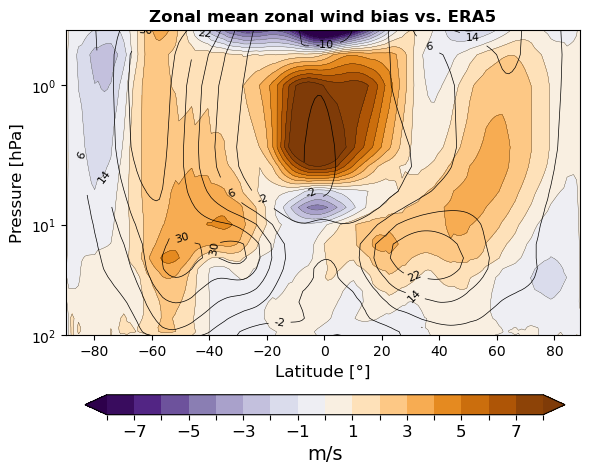

In [8]:


# parameters cell

out_path = save_path +  "/figures"
print(out_path)


input_paths = [os.path.dirname(path.rstrip(os.sep)) for path in input_paths]

input_names = [model_name]
exps = list(range(model_start, model_end+1))
saved_filenames=[]
variables=['u','t']
res=[320, 160]

clim=reanalysis
figsize=(6, 4)
contour_outline_thickness = .2

# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
# Mean Deviation
def md(predictions, targets):
    return (predictions - targets).mean()

class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))
        
        
for variable in variables:
    if variable=='t':
        clim_var='T'
        climatology_file = 'ERA5_T.nc'
        title='Zonal mean temperate bias vs. ERA5'
        climatology_path =  observation_path+'/era5/netcdf/'
        levels = np.linspace(-8, 8, 17)
        levels2=np.linspace(190,300,12)
        labels='°C'
    if variable=='u':
        clim_var='U'
        climatology_file = 'ERA5_U.nc'
        title='Zonal mean zonal wind bias vs. ERA5'
        climatology_path =  observation_path+'/era5/netcdf/'
        levels = np.linspace(-8, 8, 17)
        levels2=np.linspace(-10,30,6)
        labels='m/s'

    # Load NCEP2 reanalysis data
    ERA5_CRF = cdo.timmean(input=str(climatology_path)+'/'+str(climatology_file),returnArray=clim_var)

    # Load model Data
    def load_parallel(variable,path):
        data1 = cdo.timmean(input="-zonmean -remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=variable)
        return data1

    data = OrderedDict()
    for exp_path, exp_name  in zip(input_paths, input_names):
        data[exp_name] = {}
        datat = []
        t = []
        temporary = []
        for exp in tqdm(exps):

            path = exp_path+'/oifs/atm_remapped_1m_pl_'+variable+'_1m_pl_'+f'{exp:04d}-{exp:04d}.nc'
            temporary = dask.delayed(load_parallel)(variable,path)
            t.append(temporary)

        with ProgressBar():
            datat = dask.compute(*t, scheduler='threads')
        data[exp_name][variable] = np.squeeze(datat)
        
    data_model = OrderedDict()
    data_model_mean = OrderedDict()


    for exp_name in input_names:
        data_model[exp_name] = np.mean(data[exp_name][variable],axis=0) 
        data_model_mean[exp_name] = data_model[exp_name]
    data_reanalysis_mean = np.squeeze(np.fliplr(ERA5_CRF))

    print(np.shape(data_model_mean[exp_name]))
    print(np.shape(data_reanalysis_mean))

    rmsdval = rmsd(data_model_mean[exp_name],data_reanalysis_mean)
    mdval = md(data_model_mean[exp_name],data_reanalysis_mean)


    nrows, ncol = define_rowscol(input_paths)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    i = 0

    x = [100,92.5,85,70,60,50,40,30,25,20,15,10,7,5,3,2,1,0.5,0.1]
    lat = np.arange(-90, 90, 1.125)

    for key in input_names:

        axes[i]=plt.subplot(nrows,ncol,i+1)
        imf=plt.contourf(lat, x, data_model_mean[exp_name]-
                        data_reanalysis_mean, cmap=plt.cm.PuOr_r, 
                         levels=levels, extend='both',
                         zorder=1)
        line_colors = ['black' for l in imf.levels]
        imc=plt.contour(lat, x, data_model_mean[exp_name]-
                        data_reanalysis_mean, colors=line_colors, 
                        levels=levels, linewidths=contour_outline_thickness,
                        zorder=2)
        ima=plt.contour(lat, x, data_model_mean[exp_name], colors=line_colors, 
                        levels=levels2, linewidths=.5,
                        zorder=3)
        plt.clabel(ima, inline=1, fontsize=8, fmt='%2.0f')
        axes[i].set_ylabel('Pressure [hPa]',fontsize=12)
        axes[i].set_xlabel('Latitude [°]',fontsize=12)

        axes[i].set_title(title,fontweight="bold")
        axes[i].set(xlim=[min(lat), max(lat)], ylim=[min(x), max(x)])
        #axes[i].invert_xaxis()
        axes[i].invert_yaxis()
        axes[i].set_yscale('symlog')


        plt.tight_layout() 

        i = i+1

        cbar_ax_abs = fig.add_axes([0.15, -0.05, 0.8, 0.05])
        cbar_ax_abs.tick_params(labelsize=12)
        cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
        cb.set_label(label=labels, size='14')
        cb.ax.tick_params(labelsize='12')
        #plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
        #plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))

    for label in cb.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)


    ofile='_part11_zonal_plots_'+variable[0]+'zonal_mean_vs_ERA5'

    if ofile is not None:
        plt.savefig(out_path+"/"+tripyrun_name +ofile, dpi=dpi,bbox_inches='tight')
        saved_filenames.append(out_path+tripyrun_name+ofile+'.png')

# Mark script as completed
update_status(SCRIPT_NAME, "Completed")

In [49]:
input_paths

['/work/ab0995/a270275/experiments/awicm3test011/outdata']

In [30]:
input_paths

['/work/ab0995/a270275/experiments/awicm3test011/outdata']